In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, Normalizer,PowerTransformer
from sklearn.model_selection import train_test_split
from tensorflow.keras import losses

import matplotlib.pyplot as plt

# Design id
#
# * 0: Non-linear front-end with ADC quantization
# * 1: Non-linear front-end without ADC quantization
# * 2: Linear front-end with ADC quantization
# * 3: Linear front-end without ADC quantization
id = 1
it = 1      # iteration

nrx = 16    # num of receiver antennas
nsnr = 31   # num of snr points
nx = 10000  # num of tx samples

## Read the data fromt the input files

In [2]:
df = pd.read_csv(r'../../datasets/rx_1/idata_'+str(it)+'.csv')
# Random tx data
x = np.char.replace(np.array(df['x'],dtype=str),'i','j').astype(np.complex)

# Channel w
w = np.array([np.char.replace(np.array(df['w_'+str(i+1)],dtype=str),'i','j').astype(np.complex)
              for i in range(nrx)], dtype=complex)

y_ant = np.array([np.char.replace(np.array(df['yant_'+str(isnr*nrx+irx+1)],dtype=str),'i','j').astype(np.complex)
              for isnr in range(nsnr) for irx in range(nrx) ], dtype=complex).T.reshape(nx*nsnr,nrx)

df = pd.read_csv(r'../../datasets/rx_1/odata_'+str(id+1)+'_'+str(it)+'.csv')
y_rffe = np.array([np.char.replace(np.array(df['yrffe_'+str(isnr*nrx+irx+1)],dtype=str),'i','j').astype(np.complex)
                    for isnr in range(nsnr) for irx in range(nrx)]).T.reshape(nx*nsnr,nrx)

df = pd.read_csv(r'../../datasets/rx_1/param_1_'+str(id+1)+'_'+str(it)+'.csv')
power_in = df['Pin']

# Print the shape for some of the arrays
print(f'y_ant shape: {y_ant.shape}')
print(f'y_rffe shape: {y_rffe.shape}')

y_ant shape: (310000, 16)
y_rffe shape: (310000, 16)


In [3]:
wx = (w*x).transpose()
wx.shape

(10000, 16)

In [4]:
wx = np.repeat(wx,[nsnr],axis=0)
wx.shape

(310000, 16)

In [19]:
# Baseline data
y_rffe = y_rffe.reshape(nx, nsnr, nrx)

# Baseline data
y_ant = y_ant.reshape(nx, nsnr, nrx)

wx = wx.reshape(nx, nsnr, nrx)

print(f'y_ant shape: {y_ant.shape}')
print(f'y_rffe shape: {y_rffe.shape}')
print(f'wx shape: {wx.shape}')

y_ant shape: (10000, 31, 16)
y_rffe shape: (10000, 31, 16)
wx shape: (10000, 31, 16)


In [6]:
y_ant_norm = y_ant / np.linalg.norm(y_ant,axis=0)
y_rffe_norm = y_rffe / np.linalg.norm(y_rffe,axis=0)
wx_norm = wx / np.linalg.norm(wx,axis=0)

## Define some helper functions

In [7]:
def snr(Phi):
    xh = sum(Phi.T*np.conj(w),0)/np.sum(np.abs(w)**2,0)
    a = np.mean(np.conj(xh)*x)/np.mean(np.abs(x)**2)
    d_var = np.mean(np.abs(xh - a*x)**2)
    snr_out = 10*np.log10(np.abs(a)**2/d_var)
    return snr_out

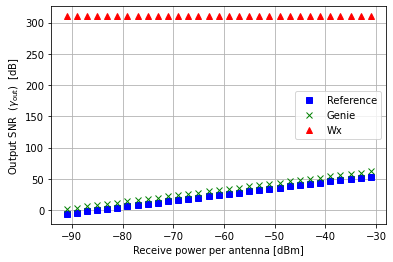

In [8]:

# Baseline data
base = y_rffe_norm

# Baseline data
gold = y_ant_norm

base_snr = np.zeros(nsnr)
gold_snr = np.zeros(nsnr)
wx_snr = np.zeros(nsnr)

for isnr in range(nsnr):
    base_snr[isnr] = snr(base[:, isnr, :])
    gold_snr[isnr] = snr(gold[:, isnr, :])
    wx_snr[isnr] = snr(wx_norm[:, isnr, :])

plt.plot(power_in, base_snr, 'bs')
plt.plot(power_in, gold_snr, 'gx')
plt.plot(power_in, wx_snr, 'r^')
plt.grid()
plt.xlabel('Receive power per antenna [dBm]')
plt.ylabel('Output SNR $\;(\gamma_\mathrm{out})\;$ [dB]')
plt.legend(['Reference', 'Genie','Wx'])

## Prepare the training and test data

In [9]:
y_ant_norm_all = y_ant_norm.reshape(nx*nsnr,nrx)
y_rffe_norm_all = y_rffe_norm.reshape(nx*nsnr,nrx)
wx_norm_all = wx_norm.reshape(nx*nsnr,nrx)
r = np.hstack((wx_norm_all.real, wx_norm_all.imag))
X = np.hstack((y_rffe_norm_all.real, y_rffe_norm_all.imag))

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, r, shuffle=True, test_size=0.1)


# scale_in = StandardScaler(with_mean=True, with_std=True).fit(x_train)
# scale_out = StandardScaler(with_mean=True, with_std=True).fit(y_train)
scale_in = PowerTransformer().fit(x_train)
scale_out = PowerTransformer().fit(y_train)

x_train = scale_in.transform(x_train)
x_test = scale_in.transform(x_test)
y_train = scale_out.transform(y_train)
y_test = scale_out.transform(y_test)

print(f'x_train shape: {x_train.shape}')

x_train shape: (279000, 32)


In [11]:
x_train[:5,:]

array([[ 0.3619969 , -0.35835756, -0.36936388, -0.25160535, -0.18657381,
        -0.21436782, -0.36411924, -0.12826477, -0.40820758,  0.3160973 ,
        -0.45335291,  0.27447852,  0.20806813, -0.21110829, -0.16089139,
        -0.22921187, -0.29709169,  0.10713772,  0.25487256, -0.2291815 ,
         0.38414527,  0.3562614 ,  0.05383513, -0.39272165, -0.06366589,
         0.180018  , -0.01428805,  0.34128559, -0.30535923,  0.3803136 ,
         0.35912406, -0.29743431],
       [ 2.21227143, -1.9735995 ,  2.10767939, -2.33752812, -2.41389118,
        -0.13758176,  0.55495629,  2.29479952, -2.33158382, -0.47131863,
         2.52365012, -1.5378263 ,  1.80429143, -0.9701489 , -2.06611686,
        -1.7290372 ,  1.17459805,  1.48691676,  1.49349471,  0.8866057 ,
        -0.81446173,  2.5434113 ,  2.45241003,  1.23490811, -1.05434664,
        -2.52804636, -0.28806974,  2.03494325,  1.68530141, -2.32627473,
        -1.5120001 , -1.83248458],
       [ 1.19492604, -1.44012132,  1.30093189, -1.2849

## Create and train the neural network

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='linear'),
    tf.keras.layers.Dense(64, activation='linear'),
    tf.keras.layers.Dense(128, activation='linear'),
    tf.keras.layers.Dense(256, activation='linear'),
    tf.keras.layers.Dense(128, activation='linear'),
    tf.keras.layers.Dense(64, activation='linear'),
    tf.keras.layers.Dense(32, activation='linear')
])
model.compile(optimizer='sgd', loss=losses.MeanSquaredError())
# model.compile(optimizer='sgd', loss=losses.CosineSimilarity(axis=1))


model.fit(x_train, y_train,
          epochs=10,
          batch_size=256,
          shuffle=True,
          validation_data=(x_test, y_test))

Epoch 1/10
1090/1090 [==============================] - 5s 4ms/step - loss: 0.7670 - val_loss: 0.5161
Epoch 2/10
1090/1090 [==============================] - 3s 3ms/step - loss: 0.4956 - val_loss: 0.4490
Epoch 3/10
1090/1090 [==============================] - 4s 3ms/step - loss: 0.4403 - val_loss: 0.4209
Epoch 4/10
1090/1090 [==============================] - 4s 3ms/step - loss: 0.4196 - val_loss: 0.4137
Epoch 5/10
1090/1090 [==============================] - 4s 3ms/step - loss: 0.4149 - val_loss: 0.4103
Epoch 6/10
1090/1090 [==============================] - 4s 4ms/step - loss: 0.4101 - val_loss: 0.4024
Epoch 7/10
1090/1090 [==============================] - 4s 3ms/step - loss: 0.4019 - val_loss: 0.3966
Epoch 8/10
1090/1090 [==============================] - 3s 3ms/step - loss: 0.3987 - val_loss: 0.3959
Epoch 9/10
1090/1090 [==============================] - 3s 3ms/step - loss: 0.3984 - val_loss: 0.3959
Epoch 10/10
1090/1090 [==============================] - 3s 3ms/step - loss: 0.398

## Compare the output-SNR of the neural network with the baseline

In [16]:
X.shape

(310000, 32)

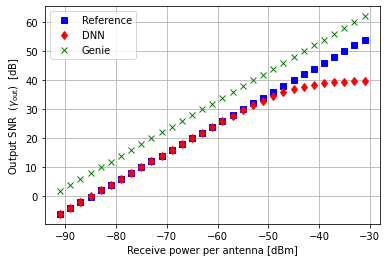

In [18]:
# Use the NN to predict the new data
pred = model(scale_in.transform(X)).numpy()

# Find the complex data
pred = pred[:, :16] + 1j * pred[:, 16:]
pred = pred.reshape(nx, nsnr, nrx)

# Baseline data
base = y_rffe.reshape(nx, nsnr, nrx)

# Baseline data
gold = y_ant.reshape(nx, nsnr, nrx)

pred_snr = np.zeros(nsnr)
base_snr = np.zeros(nsnr)
gold_snr = np.zeros(nsnr)

for isnr in range(nsnr):
    pred_snr[isnr] = snr(pred[:, isnr, :])
    base_snr[isnr] = snr(base[:, isnr, :])
    gold_snr[isnr] = snr(gold[:, isnr, :])

plt.plot(power_in, base_snr, 'bs')
plt.plot(power_in, pred_snr, 'rd')
plt.plot(power_in, gold_snr, 'gx')
plt.grid()
plt.xlabel('Receive power per antenna [dBm]')
plt.ylabel('Output SNR $\;(\gamma_\mathrm{out})\;$ [dB]')
plt.legend(['Reference', 'DNN', 'Genie'])